In [1]:
import pandas as pd
import numpy as np


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt

from mlxtend.frequent_patterns import apriori, association_rules

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [11]:
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import LabelEncoder

<h1><i>Importation du dataset</i></h1>

In [124]:
df_train = pd.read_csv('train_Insurance.csv')
df_test = pd.read_csv('test_Insurance.csv')

<h1><i>Preprocessing</i></h1>

In [127]:
def transform_dataframe(df):
    # Effacer l'observation Customer ID
    df.drop(columns=["Customer Id"], inplace=True)
    # Remplir les valeurs nulls
    df['Garden'].ffill(inplace=True)
    df['Building Dimension'].ffill(inplace=True)
    df['Geo_Code'].ffill(inplace=True)
    
    # Changer les valeurs en valeurs discret
    df["NumberOfWindows"] = df["NumberOfWindows"].apply(lambda x: 0 if x == 'without' else x)
    df["Building_Painted"] = df["Building_Painted"].apply(lambda x: 1 if x == 'N' else 0)
    df["Building_Fenced"] = df["Building_Fenced"].apply(lambda x: 1 if x == 'N' else 0)
    df["Garden"] = df["Garden"].apply(lambda x: 1 if x == 'V' else 0)
    df["Settlement"] = df["Settlement"].apply(lambda x: 1 if x == 'R' else 0)  # if Settlement R => 1 else U => 0
    df["Claim"] = df["Claim"].apply(lambda x: 1 if x == 'oui' else 0)
    
    # Convertir Geo_Code en valeurs numériques
    label_encoder = LabelEncoder()
    df["Geo_Code"] = label_encoder.fit_transform(df["Geo_Code"])
    
    # Apply OneHotEncoder on Building_Type
    encoder = OneHotEncoder(sparse_output=False)
    encoded_array = encoder.fit_transform(df[['Building_Type']])
    encoded_columns = encoder.get_feature_names_out(['Building_Type'])
    encoded_df = pd.DataFrame(encoded_array, columns=encoded_columns, index=df.index)
    
    # Drop the 'Building_Type' column and add the encoded columns
    df = pd.concat([df.drop(columns=['Building_Type']), encoded_df], axis=1)
    
    # Handle potential range-like columns (e.g., '>=10') by converting them to numeric
    def convert_to_numeric(value):
        try:
            # Try to convert to a float directly
            return float(value)
        except ValueError:
            # If it fails, try to parse ranges like '>=10'
            if isinstance(value, str) and value.startswith('>='):
                return float(value[2:])  # Convert to the number part
            return None  # Handle other cases (or add more logic for specific cases)
    
    # Apply conversion to any column where values might be strings
    for column in df.select_dtypes(include=['object']).columns:
        df[column] = df[column].apply(convert_to_numeric)
    
    # Handle any remaining missing values after conversion
    df.fillna(0, inplace=True)  # Or use another strategy to handle missing values
    
    # Normalize the numeric columns
    numeric_columns = df.select_dtypes(include=['number']).columns
    scaler = MinMaxScaler()
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

    # Move the 'Claim' column to the last position
    claim_col = df.pop('Claim')  # Remove the 'Claim' column and store it
    df['Claim'] = claim_col  # Add the 'Claim' column back to the DataFrame as the last column
    
    return df


In [128]:
df_train = transform_dataframe(df_train)
df_test = transform_dataframe(df_test)

C:\Users\houss\AppData\Local\Temp\ipykernel_14608\1596369428.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Garden'].ffill(inplace=True)
C:\Users\houss\AppData\Local\Temp\ipykernel_14608\1596369428.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing

In [129]:
df_train

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,NumberOfWindows,Geo_Code,Building_Type_Fire-resistive,Building_Type_Non-combustible,Building_Type_Ordinary,Building_Type_Wood-framed,Claim
0,0.00,1.0,1.0,1.0,0.0,1.0,0.0,0.059456,0.0,0.713645,0.0,0.0,0.0,1.0,0.0
1,0.00,1.0,0.0,1.0,0.0,1.0,0.0,0.043140,0.0,0.505386,0.0,1.0,0.0,0.0,0.0
2,0.25,1.0,1.0,0.0,1.0,0.0,1.0,0.239119,0.4,0.182226,0.0,1.0,0.0,0.0,1.0
3,1.00,0.0,0.0,1.0,0.0,1.0,0.0,0.028744,0.0,0.444345,0.0,0.0,0.0,1.0,1.0
4,0.00,1.0,0.0,1.0,0.0,1.0,0.0,0.043140,0.0,0.416517,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5007,0.25,1.0,0.0,1.0,0.0,1.0,0.0,0.026345,0.0,0.199282,0.0,0.0,1.0,0.0,1.0
5008,0.00,0.0,0.0,0.0,1.0,0.0,1.0,0.047939,0.4,0.024237,1.0,0.0,0.0,0.0,0.0
5009,0.75,1.0,1.0,0.0,1.0,0.0,1.0,0.022986,0.3,0.966786,0.0,0.0,1.0,0.0,0.0
5010,0.00,0.0,0.0,0.0,1.0,0.0,1.0,0.025673,0.4,0.686715,1.0,0.0,0.0,0.0,0.0


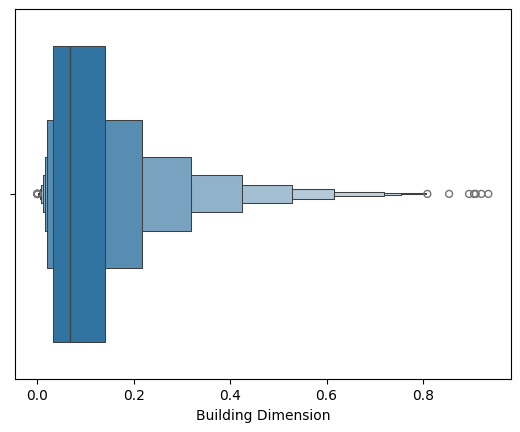

In [135]:
sns.boxenplot(data=df_train, x="Building Dimension")
plt.show()

<h1><i>SMOTE</i></h1>

In [130]:
#SMOTE
X = df_train.iloc[:, :-1]
y = df_train.loc[:,'Claim']
# Apply SMOTE + Tomek
smote_tomek = SMOTETomek(sampling_strategy='auto')
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)
df_train = pd.DataFrame(X_resampled, columns=["YearOfObservation",	"Insured_Period",	"Residential",	"Building_Painted",	"Building_Fenced",	"Garden",	"Settlement",	"Building Dimension", "NumberOfWindows",	"Geo_Code",	"Building_Type_Fire-resistive",	"Building_Type_Non-combustible",	"Building_Type_Ordinary",	"Building_Type_Wood-framed"])
df_train["Claim"] = y_resampled

<h1><i>Logistic Regression</i></h1>

In [132]:
# Step 1: Split into features and target for both train and test data
X_train = df_train.drop(columns=['Claim'])  # Features for training
y_train = df_train['Claim']  # Target for training

X_test = df_test.drop(columns=['Claim'])  # Features for testing
y_test = df_test['Claim']  # Target for testing

# Step 2: Train Logistic Regression
model = LogisticRegression()
model.fit(X_train, y_train)

# Step 3: Evaluate the Model
y_pred = model.predict(X_test)

print("Logistic Regression | Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Logistic Regression | Accuracy: 0.7051700046576619
Confusion Matrix:
 [[1220  419]
 [ 214  294]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.74      0.79      1639
         1.0       0.41      0.58      0.48       508

    accuracy                           0.71      2147
   macro avg       0.63      0.66      0.64      2147
weighted avg       0.75      0.71      0.72      2147



<h1><i>Random Forest</i></h1>

In [133]:
# Step 1: Split into features and target for both train and test data
X_train = df_train.drop(columns=['Claim'])  # Features for training
y_train = df_train['Claim']  # Target for training

X_test = df_test.drop(columns=['Claim'])  # Features for testing
y_test = df_test['Claim']  # Target for testing

# Step 2: Train RandomForest Classifier
model = RandomForestClassifier(random_state=42)  # You can adjust the hyperparameters here
model.fit(X_train, y_train)

# Step 3: Evaluate the Model
y_pred = model.predict(X_test)

print("Random Forest | Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Random Forest | Accuracy: 0.7051700046576619
Confusion Matrix:
 [[1312  327]
 [ 306  202]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.80      0.81      1639
         1.0       0.38      0.40      0.39       508

    accuracy                           0.71      2147
   macro avg       0.60      0.60      0.60      2147
weighted avg       0.71      0.71      0.71      2147



<h1><i>XGBoost</i></h1>

In [134]:
# Step 1: Split into features and target for both train and test data
X_train = df_train.drop(columns=['Claim'])  # Features for training
y_train = df_train['Claim']  # Target for training

X_test = df_test.drop(columns=['Claim'])  # Features for testing
y_test = df_test['Claim']  # Target for testing

# Step 2: Train XGBoost Classifier
model = xgb.XGBClassifier(random_state=42)  # You can adjust the hyperparameters here
model.fit(X_train, y_train)

# Step 3: Evaluate the Model
y_pred = model.predict(X_test)

print("XGBoost | Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


XGBoost | Accuracy: 0.7084303679552865
Confusion Matrix:
 [[1287  352]
 [ 274  234]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.79      0.80      1639
         1.0       0.40      0.46      0.43       508

    accuracy                           0.71      2147
   macro avg       0.61      0.62      0.62      2147
weighted avg       0.72      0.71      0.72      2147

